# Amazon SageMaker IP Insights Algorithm - Alternative Approach

Here there! <br>
Welcome to this notebook and repository. This is an code example for the [blog](https://data-centric-mind.medium.com/ip-insights-model-add-some-11d993c0d860) series. Hope you enjoy this notebook with your coffee (or tea)!

-------

## Introduction

In the previous notebooks, we explained how the IP Insights model works and how the data were simulated. However, it may also occur to you, hey, we are just trying to seperate two very different distributions. Is there another approach we can take ?

In this notebook, we want to explore the possiblity of creating a simple benchmark model to detect malicious login events. 


#### Unsupervised anomaly detection for susicipous IP addresses

-------
1.[ObtainASN](#ObtainASN) 

2.[CreateTestingData](#CreateTestingData)

3.[RandomnessTest](#RandomnessTest)

4.[AddingSpice](#AddingSpice)
 
5.[Summary](#Summary)

# ObtainASN

If you recall the data sampling approach, we first sample ASN for each user with certian patterns, and then an IP will be drawn from each ASN randomly. Therefore, the assumption here is, the ASN from normal users should follow a pattern of some kind. 
<br>
<br>
To obtain an accurate ASN informtion, we repeat the data simultion process and save the ASN into our logs. With real time logs and traffic, you can do a ASN lookup with this package.

In [9]:
from os import path
import generate_data_asn
from generate_data_asn import generate_dataset
import importlib
importlib.reload(generate_data_asn)

In [167]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [11]:
data_generation_file = "generate_data_asn.py"  # Synthetic data generation module
log_file = "ipinsights_web_traffic_asn_added.log"
if not path.exists(data_generation_file):
    print("file couldn't find")

In [17]:
# We simulate traffic for 10,000 users. This should yield about 3 million log lines (~700 MB).
NUM_USERS = 10000
generate_dataset(NUM_USERS, log_file)

Starting User Activity Simulation
Loaded ASN List: 827696 ASNs.


100%|██████████| 10000/10000 [00:27<00:00, 367.41users/s]


Loaded ASN List: 827696 ASNs.
Loaded ASN List: 827696 ASNs.
Loaded ASN List: 827696 ASNs.
Loaded ASN List: 827696 ASNs.
Finished simulating web activity for 10000 users.


I have modified the generate_data.py script to include the asn into each log as the first field. Let's take a look at the log sample we created. 

In [22]:
!wc -l $log_file

 3004115 ipinsights_web_traffic_asn_added.log


In [19]:
!head -3 $log_file

752385 208.131.175.34 - user_126 [10/Nov/2018:14:38:27 +0000] "GET /login_success HTTP/1.1" 200 476 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/555.33 (KHTML, like Gecko) Chrome/1.1.1111.100 Safari/555.355"
752389 208.131.179.252 - user_126 [11/Nov/2018:19:21:42 +0000] "GET /login_success HTTP/1.1" 200 476 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/555.33 (KHTML, like Gecko) Chrome/1.1.1111.100 Safari/555.355"
737749 206.213.213.11 - user_126 [09/Nov/2018:17:48:15 +0000] "GET /login_success HTTP/1.1" 200 476 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/555.33 (KHTML, like Gecko) Chrome/1.1.1111.100 Safari/555.355"


In [50]:
import pandas as pd
df_raw = pd.read_csv(
    log_file,
    sep=" ",
    na_values="-",
    header=None,
    names=[
        "asn",
        "ip_address",
        "rcf_id",
        "user",
        "timestamp",
        "time_zone",
        "request",
        "status",
        "size",
        "referer",
        "user_agent",
    ],
)
df_raw.head()

,asn,ip_address,rcf_id,user,timestamp,time_zone,request,status,size,referer,user_agent
0,752385,208.131.175.34,NaN,user_126,[10/Nov/2018:14:38:27,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
1,752389,208.131.179.252,NaN,user_126,[11/Nov/2018:19:21:42,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
2,737749,206.213.213.11,NaN,user_126,[09/Nov/2018:17:48:15,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
3,737743,206.213.190.198,NaN,user_126,[04/Nov/2018:22:10:16,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
4,737768,206.213.254.157,NaN,user_126,[13/Nov/2018:20:14:58,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...


Let's do a quick summary of the #ASN for each user. So as least half of the users have up to 3 asns. But there are some extreme values which are likely the travellers we have defined. 

In [51]:
df_raw.groupby(['user']).agg({'asn':'nunique'}).value_counts().describe()

count    294.000000
mean      34.013605
std       63.813560
min        1.000000
25%        1.000000
50%        3.000000
75%       31.500000
max      300.000000
dtype: float64

In [135]:
df_raw["timestamp"] = pd.to_datetime(df_raw["timestamp"], format="[%d/%b/%Y:%H:%M:%S")
df_raw["timestamp"].describe(datetime_is_numeric=True)

count                          3004115
mean     2018-11-09 00:03:36.151624448
min                2018-11-04 00:00:01
25%                2018-11-06 12:02:27
50%                2018-11-09 00:06:42
75%                2018-11-11 12:03:01
max                2018-11-14 00:00:00
Name: timestamp, dtype: object

In [54]:
# Check if they are all in the same timezone
num_time_zones = len(df_raw["time_zone"].unique())
num_time_zones

1

In [55]:
from datetime import datetime
time_partition = (
    datetime(2018, 11, 11, tzinfo=pytz.FixedOffset(0))
    if num_time_zones > 1
    else datetime(2018, 11, 11)
)

In [57]:
## create model training and testing data

df = df_raw[["user", "ip_address", "timestamp", "asn"]]

train_df = df[df["timestamp"] <= time_partition]
test_df = df[df["timestamp"] > time_partition]

# Shuffle train data
train_df = train_df.sample(frac=1)

In [58]:
train_df.shape

(2101805, 4)

In [59]:
test_df.shape

(902310, 4)

# CreateTestingData

Next, let's create a sample with simulated bad traffic added. Therefore, we can use this data set to verify test if our approach would work. 

In [63]:
def create_test_case(train_df, test_df, num_samples, attack_freq):
    """Creates a test case from provided train and test data frames.

    This generates test case for accounts that are both in training and testing data sets.

    :param train_df: (panda.DataFrame with columns ['user', 'ip_address']) training DataFrame
    :param test_df: (panda.DataFrame with columns ['user', 'ip_address']) testing DataFrame
    :param num_samples: (int) number of test samples to use
    :param attack_freq: (float) the ratio of negative_samples:positive_samples to generate for test case
    :return: DataFrame with both good and bad traffic, with labels
    """
    # Get all possible accounts. The IP Insights model can only make predictions on users it has seen in training
    # Therefore, filter the test dataset for unseen accounts, as their results will not mean anything.
    valid_accounts = set(train_df["user"])
    valid_test_df = test_df[test_df["user"].isin(valid_accounts)]

    good_traffic = valid_test_df.sample(num_samples, replace=False)
    good_traffic = good_traffic[["user", "ip_address", "asn"]]
    good_traffic["label"] = 0

    # Generate malicious traffic
    num_bad_traffic = int(num_samples * attack_freq)
    bad_traffic_accounts = np.random.choice(
        list(valid_accounts), size=num_bad_traffic, replace=True
    )
    # bad_traffic_ips = [draw_ip() for i in range(num_bad_traffic)]
    # bad_traffic = pd.DataFrame({"user": bad_traffic_accounts, "ip_address": bad_traffic_ips})
    # bad_traffic["label"] = 1
    bad_traffic_ips = [draw_ip() for i in range(num_bad_traffic)]
    bad_traffic = pd.DataFrame({"user": bad_traffic_accounts, "ip_address": [t[1] for t in bad_traffic_ips], "asn": [t[0] for t in bad_traffic_ips]})
    bad_traffic["label"] = 1

    # All traffic labels are: 0 for good traffic; 1 for bad traffic.
    all_traffic = good_traffic.append(bad_traffic)

    return all_traffic

In [66]:
NUM_SAMPLES = 100000
test_case = create_test_case(train_df, test_df, num_samples=NUM_SAMPLES, attack_freq=1)
test_case.head()

,user,ip_address,asn,label
992579,user_3178,213.191.223.86,788436,0
108392,user_391,182.55.57.155,505955,0
1167651,user_3670,24.54.216.171,30720,0
307734,user_938,92.46.20.96,233411,0
1869475,user_6149,196.24.69.49,631391,0


In [67]:
test_case['label'].value_counts()

0    100000
1    100000
Name: label, dtype: int64

Tada! <br>
We have create a balanced data set with 200, 000 login entries. Lable 0 means it's a normal login and label 1 means it's a malicious login.

Next, let's take a look up how and the key feature here, how many times each user login from the same ASN, aka, count of login group by user and ASN. 

--------
Quick note: I am a big fan of this book - <data storytelling>, where some principlies of how to present and visualize your data is summarized in detail. Feel free to take a look at it. In my day to day, I also follow the same princeple to tell the stories about my data. The sample code of the visualization style can be found in this repo. 

In [103]:
freq_count_good = test_case[test_case['label'] == 0].groupby('user').agg({'asn': 'count', 'label':'max'}).reset_index()
freq_count_bad = test_case[test_case['label'] == 1].groupby('user').agg({'asn': 'count', 'label':'max'}).reset_index()

In [88]:
good_freq = test_case[test_case['label'] == 0].groupby('user').agg({'asn': 'count'})['asn'].to_list()
bad_freq = test_case[test_case['label'] == 1].groupby('user').agg({'asn': 'count'})['asn'].to_list()

In [82]:
test_case[test_case['label'] == 1].groupby('user').agg({'asn': 'count'}).describe()

,asn
count,9998.000000
mean,10.002000
std,3.155564
min,1.000000
25%,8.000000
50%,10.000000
75%,12.000000
max,24.000000


In [96]:
freq_count.head()

,user,asn,label
0,user_0,11,1
1,user_1,4,1
2,user_10,10,1
3,user_100,11,1
4,user_1000,7,1


In [92]:
import numpy as np
import matplotlib
from matplotlib import transforms, pyplot as plt
import seaborn as sns
%matplotlib inline

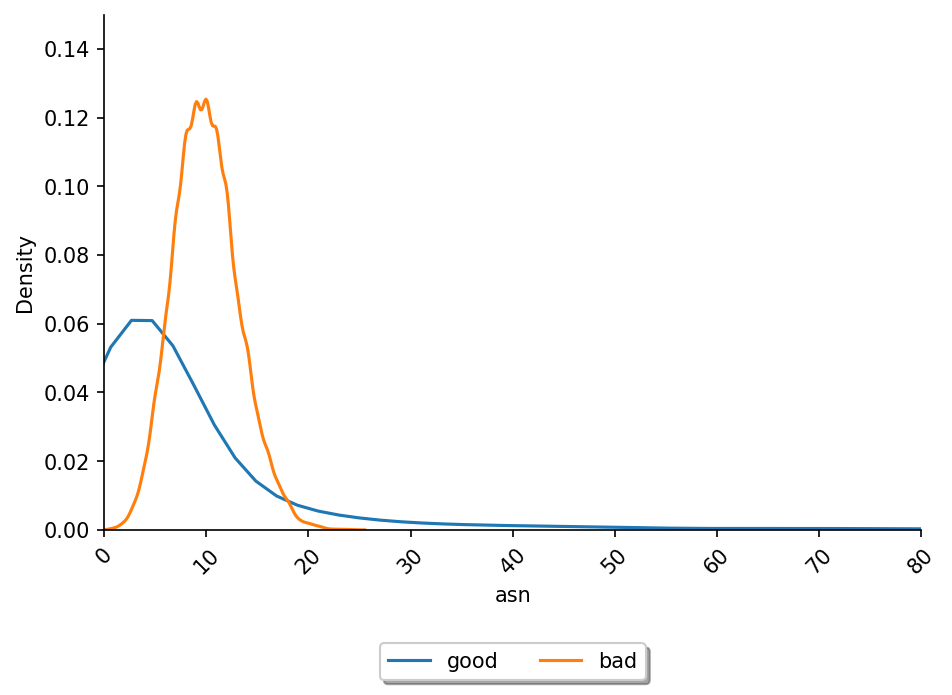

In [168]:
# plt.ioff()
fig, ax1 = plt.subplots(figsize=(8.2, 6.09), dpi=150);
_=fig.subplots_adjust(left=0.104, right=0.768, top=0.751, bottom=0.187);
_=sns.distplot(freq_count_good['asn'], hist = False, kde = True, label = 'good', ax = ax1);
_=sns.distplot(freq_count_bad['asn'], hist = False, kde = True,label = 'bad', ax = ax1);
_=ax1.set_xlim([0, 80]);
_=ax1.set_ylim([0, 0.15]);
# _=plt.setp(ax1);
_=plt.xticks(rotation=45);
_=ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5);
_=ax1.spines['top'].set_visible(False);
_=ax1.spines['right'].set_visible(False);
# pass

The distribution actually met our expectations that the good one follows beta and the bad one looks quite normal with a bell shape. 

# RandomnessTest


First, let's try to run a rundomness test on the two groups before we further test on each user's events. Here we use the popular run test approach. To learn about it, please check out this blog(https://data-centric-mind.medium.com/randomness-test-run-test-8333a8b956a1). 

In [170]:
from statsmodels.sandbox.stats.runs import runstest_1samp 

In [178]:
runstest_1samp(freq_count_good['asn'], cutoff = 'median')

(-1.6235589045240673, 0.10446998217497946)

In [177]:
runstest_1samp(freq_count_bad['asn'], cutoff = 'median')

(-0.6116928502987828, 0.5407409931585855)

The first returned value from is the z-stats and the second value in the tuple is the p-value. We can determinte if the data is randomly distributed based on the p-value and an ideal siginificance level. The null hypothesis is that the data is randomly distributed. If the p-value is less than the selected power, we can reject the null and we have reason to believe the data is not randomly genereated. 

Well, it looks like the first good count can be considered as rejection to null hypothesis (random distribution) at a siginificance level of 0.105. While for second test on the bad samples, we do not have enough evidence to reject it as a random distribution. 

Alright, it seems we can seperate the good and bad traffic based on the number of logins each user has on each ASN.

________

## AddingSpice

Making sense so far? OK, now let's think about how to make this more practical. I will skip most of the detailed demo for this session, as otherwise the notebook will go endless long. However, I will provide the key thoughts and functions, you are highly encouraged to try it out yourself.

1. data streams
In reality, you recieve one login & IP instead of a sequence of logins. How can you test the randonmess in this case? Maybe combining with the historical N login events and run the randomness test ? 

   You can use the two functions provided below to complete the test. 


In [72]:
def check_random(df, asn_col = 'asn'):
    """ Run randomness test on asn_col of the provided dataframe df.
    """
    # when sample size is small, remember to use correction on the data.
    s = [x for x in df[asn_col].tolist() if x is not None]
    v = runstest_1samp(s, cutoff = 'median' ,correction=True)
    return (v)

In [73]:
def get_user_p(df, label, group_col = 'user'):
    """ Function return the z and p value for randomness test for each group of observations in the df
    :para df: dataframe that contains all the observations
    :para label: str, the column which used as labels we want to seperate
    :return dataframe 
    """
    dfg = df[df['label'] == label].groupby(group_col).apply(lambda x : check_random(x))
    df_random0 = pd.DataFrame(dfg)
    df_random0.columns = ['run_test']
    df_random0['zscore'] = df_random0['run_test'].apply(lambda x: round(x[0], 3))
    df_random0['pvalue'] = df_random0['run_test'].apply(lambda x: round(x[1],3))
    return df_random0

2. ASNlookup

   When your data and IP are not sampled from a simulation, you need to a different approach to obtain the ASN info. You can use the code provided below to do a ASN lookup. 

In [36]:
# install the package and needed data 
!apt-get install python-pip python-dev -y build-essential
!apt-get update && apt-get install -y build-essential
!python -m pip install pyasn

In [23]:
!pyasn_util_download.py --latest
!pyasn_util_convert.py --single rib.20220123.1200.bz2 20220123.dat

Connecting to ftp://archive.routeviews.org
Finding most recent archive in /bgpdata/2022.01/RIBS ...
 99%, 19404KB/s
Download complete.


In [215]:
import pyasn
asndb = pyasn.pyasn('20220123.dat')

In [217]:
df['asn'] = ''
for idx, row in df.iterrows():
    df.at[idx, 'asn'] = asndb.lookup(row['ip_address'])[0]

3. Add noise

   Remember what we did in the very first notebook? We added noise into our data because you are not likely having a perfect dataset in reality. Therefore, we can use the similar approach adding some noisy logins into our good sample and see it our approach still work. The modified function can be used were provided below. 

In [60]:
import numpy as np
from generate_data_asn import draw_ip

def add_noise(train_df, user_perc, noise_per_account):
    """
    This is a modified function compared to the original one.
    Creates a test case from provided train and test data frames.

    This generates test case for accounts that are both in training and testing data sets.

    :param train_df: (panda.DataFrame with columns ['user', 'ip_address']) training DataFrame
    :param user_perc: (float, [0,1]) percentage of users have noisy IPs
    :param num_samples: (int) number of test samples to use
    :param noise_pert_account: (int) number of random logins to added to each account
    :return: DataFrame with both good and bad traffic, with labels
    """
    # Get all possible accounts. The IP Insights model can only make predictions on users it has seen in training
    # Therefore, filter the test dataset for unseen accounts, as their results will not mean anything.
    valid_accounts = set(train_df["user"])

    # Generate malicious traffic
    num_bad_account = int(len(valid_accounts) * user_perc  )
    bad_traffic_accounts = np.random.choice(
        list(valid_accounts), size=num_bad_account, replace=False
    )

    bad_traffic_ips = [draw_ip() for i in range(num_bad_account * noise_per_account)]
    bad_traffic = pd.DataFrame({"user": list(bad_traffic_accounts) * noise_per_account, "ip_address": [t[1] for t in bad_traffic_ips], "asn": [t[0] for t in bad_traffic_ips]})
    bad_traffic["label"] = 1

    # All traffic labels are: 0 for good traffic; 1 for bad traffic.

    return bad_traffic

In [45]:
noise_df = add_noise(train_df, user_perc = 0.005, noise_per_account = 20)
noise_df.head()

,user,ip_address,asn,label
0,user_803,81.31.47.98,194143,1
1,user_3028,27.247.47.138,39790,1
2,user_3489,148.246.100.34,406324,1
3,user_8068,64.28.43.186,119232,1
4,user_4528,139.139.95.111,388937,1


In [ ]:
noise_train = pd.concat([noise_df[['user', 'ip_address']], train_df], ignore_index = True)

# Summary

In this post, we covered an alternative approach of identifying abnormal login with unsupervised learning approach. There are some ideas that I brought up but not fully tested because I don't think the test results on the simulated data will make sense; 2. I donnot want the notebook to be too long.. I may come back and break this notebook into a couple ones and adding more tests and content. 

Anyways, thank you for watching to the end and hope some of the contents are beneficial to you. 

See you in the next post!